# Vehicle Detection and Tracking

## Project #4

Steps of this project are the following:

In [13]:
import os
import numpy as np
import cv2
from collections import deque
import imageio 
imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mplimg
import glob
from sklearn.cross_validation import train_test_split
from skimage.feature import hog
import matplotlib.image as mpimg
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
import time
from scipy.ndimage.measurements import label


# 1. Environment Setup
Read vehicle and non-vehicle images.  

In [35]:
#flip images to augment training set
def fliped_img(image):
    
    img_name = image.split('/')[-1]
    fliped_img_path = image.replace(img_name, 'fliped_' + img_name)
    
    img = cv2.imread(image)
    image_flipped = np.fliplr(img)
    cv2.imwrite(fliped_img_path, image_flipped)
    
    return fliped_img_path

    

output_folder = 'output_images'
cars = glob.glob('training_images/vehicles/**/*.png')
noncars = glob.glob('training_images/non-vehicles/**/*.png')

car_imgs = []
noncar_imgs = []

for car in cars:
    car_imgs.append(car)
    #car_imgs.append(fliped_img(car))

for noncar in noncars:
    noncar_imgs.append(noncar)
    #noncar_imgs.append(fliped_img(noncar))

print('Number of car images', len(car_imgs), 'and number or non-car images',  len(noncar_imgs))


Number of car images 17584 and number or non-car images 17936


Display some of the images

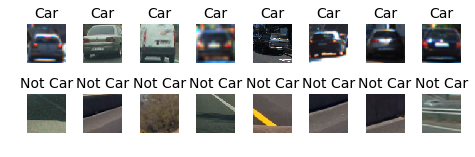

In [3]:
num_imgs = 8
fig, axs = plt.subplots(2, num_imgs, figsize=(8, 2))
fig.subplots_adjust(hspace = .8, wspace=.1)
axs = axs.ravel()

for i in np.arange(num_imgs):
    img = cv2.imread(car_imgs[np.random.randint(0, len(car_imgs))])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('Car', fontsize=14)
    axs[i].imshow(img)
    
    img = cv2.imread(noncar_imgs[np.random.randint(0, len(noncar_imgs))])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[i + num_imgs].axis('off')
    axs[i + num_imgs].set_title('Not Car', fontsize=14)
    axs[i + num_imgs].imshow(img)
    

# 2. Histogram of Oriented Gradient (HOG) Features 

Following functions are for features extraction. Functions are based on code from the Udacity's lectures.

In [4]:
# Define parameters for feature extraction
color_space = 'LUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9 # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 8 # Number of histogram bins
do_spatial = 1 # Spatial features on or off
do_hist = 1 # Histogram features on or off
do_hog = 1 # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()
spatial_feat=True 
hist_feat=True 
hog_feat=True

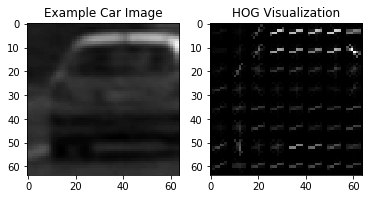

In [5]:
# Define a function to return HOG features and visualization
def get_hog_features(img,
                     vis=False, 
                     feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

    
    
    # Generate a random index to look at a car image
img = cv2.imread(car_imgs[567])
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(img, vis=True, feature_vec=False)

fig = plt.figure()
plt.subplot(121)
plt.imshow(img, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

# 3. Classifier
Code is mostly from course material.

In [6]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(16, 16)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


def extract_features(imgs):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file_p in imgs:
        file_features = []
        image = cv2.imread(file_p) # Read in each imageone by one
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      
            
        file_features = []        
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)

            file_features.append(spatial_features)
        if hist_feat == True:
             # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = [feature_image.shape[2]]
                 
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                            vis=False, feature_vec=True))
                    hog_features = np.ravel(hog_features)
                     
            else:
                feature_image = cv2.cvtColor(feature_image, cv2.COLOR_RGB2GRAY)
                hog_features = get_hog_features(feature_image[:,:], vis=False, feature_vec=True)

            file_features.append(hog_features)

        features.append(np.concatenate(file_features))

    return features 

In [7]:
car_features = extract_features(car_imgs)

print ('Car samples: ', len(car_features))

notcar_features = extract_features(noncar_imgs)

print ('Notcar samples: ', len(notcar_features))
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        

X_scaler = StandardScaler().fit(X) # Fit a per-column scaler
scaled_X = X_scaler.transform(X) # Apply the scaler to X

y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features)))) # Define the labels vector

# Split up data into randomized training and test sets
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=22)

print('Using:',orient,'orientations', pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

svc = LinearSVC(loss='hinge') # Use a linear SVC 
t=time.time() # Check the training time for the SVC
svc.fit(X_train, y_train) # Train the classifier
t2 = time.time()

print(round(t2-t, 2), 'Seconds to train SVC...')
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4)) # Check the score of the SVC


Car samples:  17584
Notcar samples:  17936
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 4860
26.4 Seconds to train SVC...
Test Accuracy of SVC =  0.9817


# Image features
Code is mostly from course material. 

In [8]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    
    x_start = 0
    x_stop = img.shape[1]
    y_start = 0
    y_stop = img.shape[0]
    
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] != None:
        x_start = x_start_stop[0]
    if x_start_stop[1] != None:
        x_stop = x_start_stop[1]
    if y_start_stop[0] != None:
        y_start = y_start_stop[0]
    if y_start_stop[1] != None:
        y_stop = y_start_stop[1]
        
    # Compute the span of the region to be searched    
    xspan = x_stop - x_start
    yspan = y_stop - y_start
    
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start 
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start 
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img):    
    
    #, spatial_size=(32, 32),
    #                    hist_bins=32, orient=9, 
    #                    pix_per_cell=8, cell_per_block=2, hog_channel=0,
    

    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                     
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy 

hist_range=(0, 256)
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

# Test Classifier
Find cars in test images

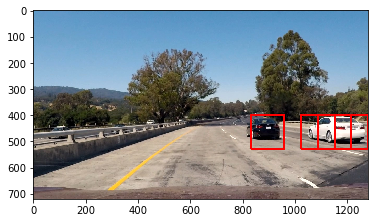

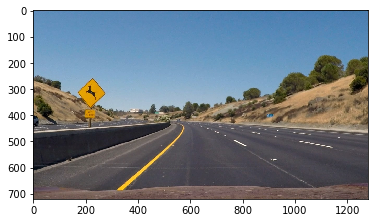

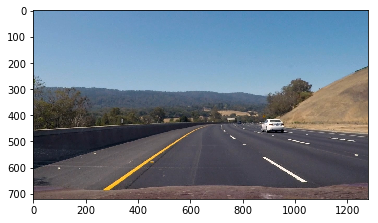

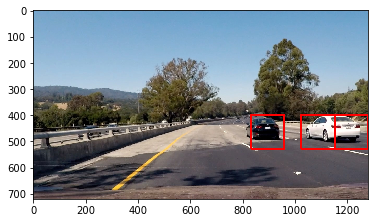

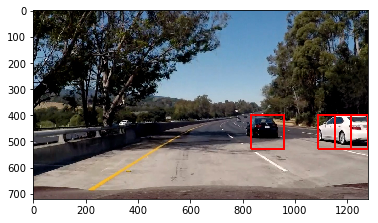

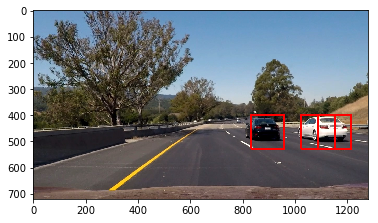

In [38]:
# A function to show an image
def show_img(img):
    if len(img.shape)==3: #Color BGR image
        plt.figure()
        plt.imshow( cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    else: # Grayscale image
        plt.figure()
        plt.imshow(img, cmap='gray')
        
def show_img1(img, ttl):
    f, axis1 = plt.subplots(1, 1, figsize=(7,5))
    if len(img.shape)==3: #Color BGR image
        axis1.imshow(img)
    else: # Grayscale image
        axis1.imshow(img, cmap='gray')
    axis1.set_title(ttl, fontsize=16)

def show_img2(img1, ttl1,img2, ttl2):
    f, (axis1, axis2) = plt.subplots(1, 1, figsize=(5,5))
    if len(img1.shape)==3: #Color BGR image
        axis1.imshow(img1)
    else: # Grayscale image
        axis1.imshow(img1, cmap='gray')
        
    if len(img2.shape)==3: #Color BGR image
        axis1.imshow(img2)
    else: # Grayscale image
        axis1.imshow(img2, cmap='gray')
        
    axis1.set_title(ttl1, fontsize=16)
    axis1.set_title(ttl2, fontsize=16)


for image_p in glob.glob('test_images/test*.jpg'):
    image = cv2.imread(image_p)
    draw_image = np.copy(image)
 

    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 720], 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5))

    hot_windows = search_windows(image, windows, svc, X_scaler)                       

    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

    show_img(window_img)

# Heat map and draw boxes

In [10]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
        #print('-------------')
        #print(box)
    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# find_cars - Updated search function

In [11]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    return img

def find_cars(img, ystart, ystop, scale, step):
    boxes = []
    draw_img = np.copy(img)   
    xstart = 0
    xstop = img.shape[1]
    img_tosearch = img[ystart:ystop,xstart:xstop,:]
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))       
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) -1
    cells_per_step = step  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(cv2.cvtColor(ctrans_tosearch, cv2.COLOR_RGB2GRAY), feature_vec=False)
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_features = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            # Extract the image patch
            subimg = ctrans_tosearch[ytop:ytop+window, xleft:xleft+window]
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))        
            test_prediction = svc.predict(test_features)
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)+xstart
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                boxes.append(((int(xbox_left), int(ytop_draw+ystart)),(int(xbox_left+win_draw),int(ytop_draw+win_draw+ystart))))
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
   
    return boxes


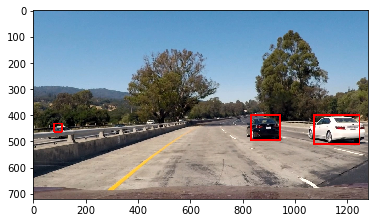

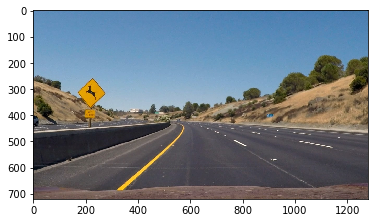

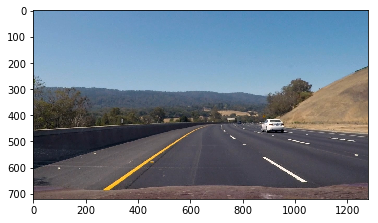

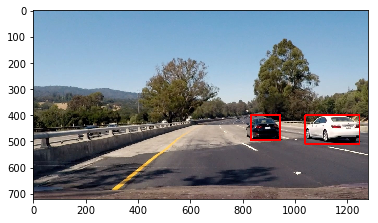

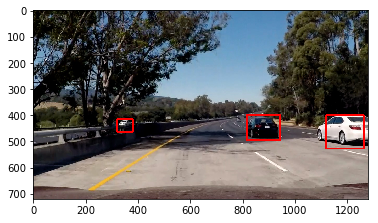

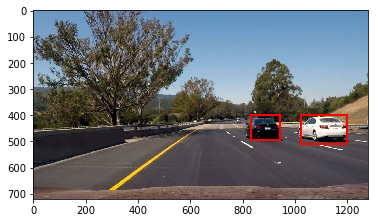

In [18]:
for image_p in glob.glob('test_images/test*.jpg'):
    image = cv2.imread(image_p)
    draw_image = np.copy(image)
 
    boxes = []
    boxes = find_cars(image, 400, 700, 1, 2) 

    heatmap_img = np.zeros_like(image[:,:,0])
    heatmap_img = add_heat(heatmap_img, boxes)
    
    heatmap_img = apply_threshold(heatmap_img, 1)
    labels = label(heatmap_img)
    
    draw_image = draw_labeled_bboxes(draw_image, labels)
                    

    show_img(draw_image)

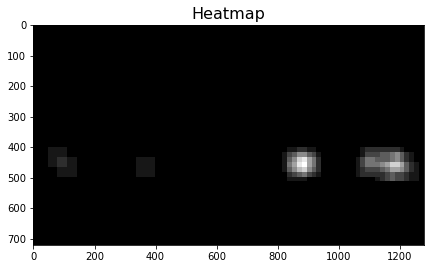

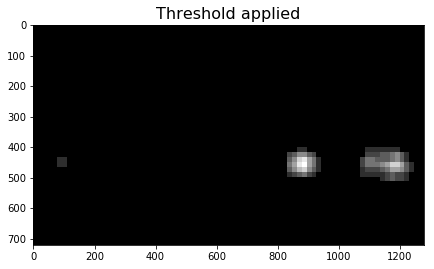

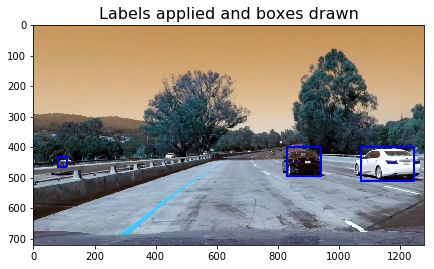

In [39]:
image = cv2.imread('test_images/test1.jpg')
draw_image = np.copy(image)
 
boxes = []
boxes = find_cars(image, 400, 700, 1, 2) 

heatmap_img = np.zeros_like(image[:,:,0])
heatmap_img = add_heat(heatmap_img, boxes)

show_img1(heatmap_img,'Heatmap')
heatmap_img = apply_threshold(heatmap_img, 1)

show_img1(heatmap_img, 'Threshold applied')

labels = label(heatmap_img)
draw_image = draw_labeled_bboxes(draw_image, labels)
                
show_img1(draw_image, 'Labels applied and boxes drawn')


In [45]:
running_avg = []
frame_limit = 5
frame_count = 0
def process_frame(image):
    
    draw_image = np.copy(image)
    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 720], 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5))

    hot_windows = search_windows(image, windows, svc, X_scaler)                       

    while(frame_limit <= len(running_avg)):
        running_avg.pop(0)
        
    running_avg.append(hot_windows)

    
    all_boxes = []
    for bxes in running_avg:
        all_boxes += bxes

    heatmap_img = np.zeros_like(image[:,:,0])
    
    heatmap_img = add_heat(heatmap_img, all_boxes)
    th_img = apply_threshold(heatmap_img, 4)
    labels = label(th_img)
    
    draw_image = draw_labeled_bboxes(draw_image, labels)
                
    if 
    show_img2(image, '', th_img,'')
    frame_count += 1
    return draw_image


test_out_file = 'test_video_out.mp4'
clip_test = VideoFileClip('test_video.mp4')
clip_test_out = clip_test.fl_image(process_frame)
%time clip_test_out.write_videofile(test_out_file, audio=False)


[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


 97%|█████████▋| 38/39 [00:07<00:00,  5.15it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

CPU times: user 21.5 s, sys: 565 ms, total: 22.1 s
Wall time: 8.3 s


In [54]:
frame_limit = 10

def pipe_line(image):
      
    boxes = []
    
    draw_img = np.copy(image)
    
    boxes= find_cars(image, 400, 500, 1.5, 2)
    #boxes += find_cars(image, 400, 600, 0.5, 2) 
    boxes += find_cars(image, 400, 600, 1.5, 2) 
    boxes += find_cars(image, 450, 720, 2.0, 2) 
    boxes += find_cars(image, 450, 720, 2.5, 2) 
    boxes += find_cars(image, 500, 720, 3.0, 2) 
    
    while(frame_limit <= len(running_avg)):
        running_avg.pop(0)
        
    running_avg.append(boxes)

    all_boxes = []
    for bxes in running_avg:
        all_boxes += bxes
        
    heatmap_img = np.zeros_like(image[:,:,0])
    
    heatmap_img = add_heat(heatmap_img, all_boxes)
    heatmap_img = apply_threshold(heatmap_img, 10)
    labels = label(heatmap_img)
    
    draw_img = draw_labeled_bboxes(draw_img, labels)

    return draw_img

test_out_file = 'test_video_out.mp4'
clip_test = VideoFileClip('test_video.mp4')

#test_out_file = 'project_video_out.mp4'
#clip_test = VideoFileClip('project_video.mp4')
clip_test_out = clip_test.fl_image(pipe_line)
%time clip_test_out.write_videofile(test_out_file, audio=False)


[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


 97%|█████████▋| 38/39 [00:16<00:00,  2.29it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

CPU times: user 48.1 s, sys: 1.8 s, total: 49.9 s
Wall time: 17.1 s
